In [40]:
# Import the libraries

import pandas as pd 
import numpy as np

from pprint import pprint

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re

import spacy

import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.corpus import wordnet

import warnings
warnings.filterwarnings("ignore")


Code references:

https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/


In [41]:
df = pd.read_csv('/Users/siriamanda/Desktop/LNU-VT-2021/Thesis/11-data-analysis/sentiment-analysis-of-reviews/01-sentiment-analysis/02-the-data-toolbox/VADER-the-data-toolbox.csv')

In [42]:
df.head()

,Unnamed: 0,date,review,rating,status,length,label,language_scores,language,scores,compound,sentiment
0,0,2021-03-09,Still difficult for me get to used to listen t...,4,completer,63,pos,"{'language': 'en', 'score': 0.9999954275035461}",en,"{'neg': 0.185, 'neu': 0.815, 'pos': 0.0, 'comp...",-0.3612,neg
1,1,2021-03-08,"very good course, i think there could be a lit...",4,completer,74,pos,"{'language': 'en', 'score': 0.9999976742625711}",en,"{'neg': 0.0, 'neu': 0.758, 'pos': 0.242, 'comp...",0.4927,pos
2,2,2021-03-08,"Instructions are clear, pace is good and thank...",5,completer,76,pos,"{'language': 'en', 'score': 0.9999965864363265}",en,"{'neg': 0.0, 'neu': 0.543, 'pos': 0.457, 'comp...",0.8126,pos
3,3,2021-03-07,"This course was amazing, mostly teaches how to...",4,completer,284,pos,"{'language': 'en', 'score': 0.9999966019854107}",en,"{'neg': 0.035, 'neu': 0.741, 'pos': 0.224, 'co...",0.9133,pos
4,4,2021-03-07,Easy exploratory course,5,completer,23,pos,"{'language': 'en', 'score': 0.9999949623133836}",en,"{'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'comp...",0.4404,pos


In [43]:
df.drop(['Unnamed: 0', 'language_scores', 'language', 'scores'], axis = 1, inplace = True)

In [44]:
df

,date,review,rating,status,length,label,compound,sentiment
0,2021-03-09,Still difficult for me get to used to listen t...,4,completer,63,pos,-0.3612,neg
1,2021-03-08,"very good course, i think there could be a lit...",4,completer,74,pos,0.4927,pos
2,2021-03-08,"Instructions are clear, pace is good and thank...",5,completer,76,pos,0.8126,pos
3,2021-03-07,"This course was amazing, mostly teaches how to...",4,completer,284,pos,0.9133,pos
4,2021-03-07,Easy exploratory course,5,completer,23,pos,0.4404,pos
...,...,...,...,...,...,...,...,...
6032,2016-01-24,This was a great starter for me. I have very l...,5,dropout,160,pos,0.6249,pos
6033,2016-01-24,Useful couple of modules for helping you get s...,4,dropout,145,pos,0.6249,pos
6034,2016-01-24,Very common curse about common data things.,3,dropout,43,neu,-0.5829,neg
6035,2016-01-24,"It is really basic course, I expected much mor...",1,dropout,130,neg,0.0000,neu


In [45]:
# Check for null values

len(df[df['review'].isna()==True])

0

In [46]:
# Drop null values

# df.dropna(inplace = True)

In [47]:
# Check for null values

# len(df[df['review'].isna()==True])

In [48]:
# Reset the index

# df = df.reset_index(drop = True)

In [49]:
# df

In [50]:
# Define a function to plot the most frequent words

def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.xticks(rotation = 45)
    plt.show()

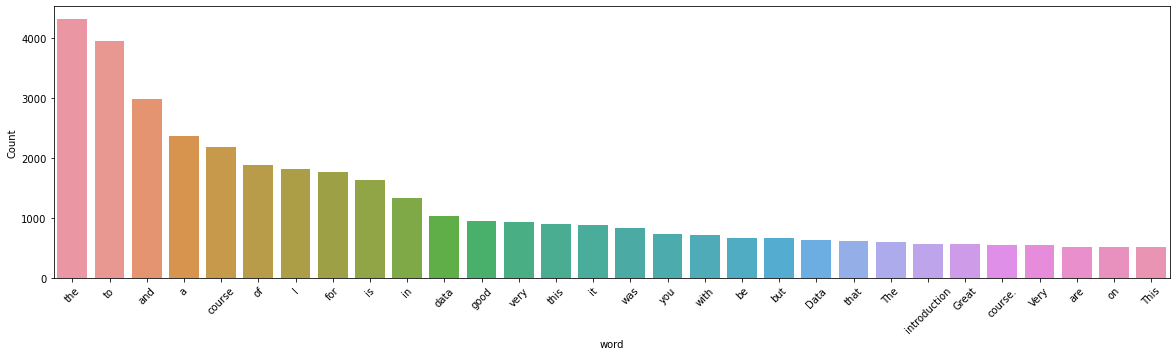

In [51]:
# The most frquent words are stop words such as 'to' and 'the' we will remove these in the preprocessing steps

freq_words(df['review'])

## Preprocessing

In [52]:
# Covert to lowercase

df['preprocessed'] =  df['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['preprocessed'].head()

0    still difficult for me get to used to listen t...
1    very good course, i think there could be a lit...
2    instructions are clear, pace is good and thank...
3    this course was amazing, mostly teaches how to...
4                              easy exploratory course
Name: preprocessed, dtype: object

In [53]:
# Remove punctuations

df['preprocessed'] = df['preprocessed'].str.replace('[^\w\s]','')
df['preprocessed'].head()

0    still difficult for me get to used to listen t...
1    very good course i think there could be a litt...
2    instructions are clear pace is good and thanks...
3    this course was amazing mostly teaches how to ...
4                              easy exploratory course
Name: preprocessed, dtype: object

In [54]:
# Remove stopwords

stop = stopwords.words('english')
stop.extend(['good', 'great', 'really', 'like', 'nice'])

df['preprocessed'] = df['preprocessed'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['preprocessed'].head()

0        still difficult get used listen computer talk
1              course think could little r programming
2      instructions clear pace thanks knowledge learnt
3    course amazing mostly teaches manage work data...
4                              easy exploratory course
Name: preprocessed, dtype: object

In [55]:
# Remove short words (length < 3)

# df['review'] = df['review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
# df['review'].head()

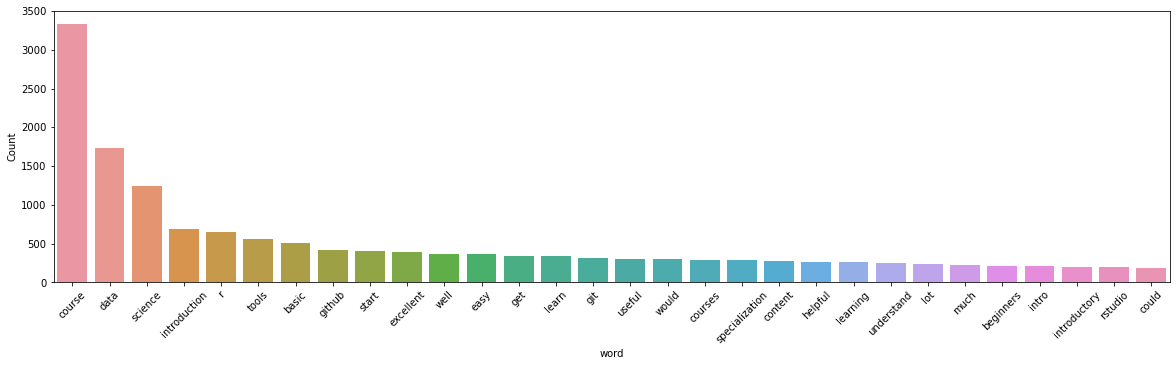

In [56]:
# Look at the most frequent words again 

freq_words(df['preprocessed'])

In [57]:
# Tokenization

tokenizer = RegexpTokenizer(r'\w+')

df['preprocessed'] = df['preprocessed'].apply(lambda x: tokenizer.tokenize(x.lower()))
df['preprocessed'].head(5)


0    [still, difficult, get, used, listen, computer...
1       [course, think, could, little, r, programming]
2    [instructions, clear, pace, thanks, knowledge,...
3    [course, amazing, mostly, teaches, manage, wor...
4                          [easy, exploratory, course]
Name: preprocessed, dtype: object

In [58]:
# Add speech tags

df['preprocessed'] = df['preprocessed'].apply(nltk.tag.pos_tag)
df['preprocessed'].head()

0    [(still, RB), (difficult, JJ), (get, VBP), (us...
1    [(course, NN), (think, NN), (could, MD), (litt...
2    [(instructions, NNS), (clear, JJ), (pace, NN),...
3    [(course, NN), (amazing, VBG), (mostly, RB), (...
4        [(easy, JJ), (exploratory, JJ), (course, NN)]
Name: preprocessed, dtype: object

In [59]:
# Define function to convert parts of speech tags to wordnet’s format

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [60]:
# Apply the function to the tagged data

df['preprocessed'] = df['preprocessed'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
df['preprocessed'].head()

0    [(still, r), (difficult, a), (get, v), (used, ...
1    [(course, n), (think, n), (could, n), (little,...
2    [(instructions, n), (clear, a), (pace, n), (th...
3    [(course, n), (amazing, v), (mostly, r), (teac...
4           [(easy, a), (exploratory, a), (course, n)]
Name: preprocessed, dtype: object

In [61]:
# Create lemmatizer

lemmatizer = WordNetLemmatizer()

# Apply to data 

df['preprocessed'] = df['preprocessed'].apply(lambda x: [lemmatizer.lemmatize(word, tag) for word, tag in x])
df['preprocessed'].head()

0    [still, difficult, get, use, listen, computer,...
1       [course, think, could, little, r, programming]
2    [instruction, clear, pace, thanks, knowledge, ...
3    [course, amaze, mostly, teach, manage, work, d...
4                          [easy, exploratory, course]
Name: preprocessed, dtype: object

In [62]:
# Join reviews

df['joined'] = df['preprocessed'].apply(lambda x: ' '.join(x))

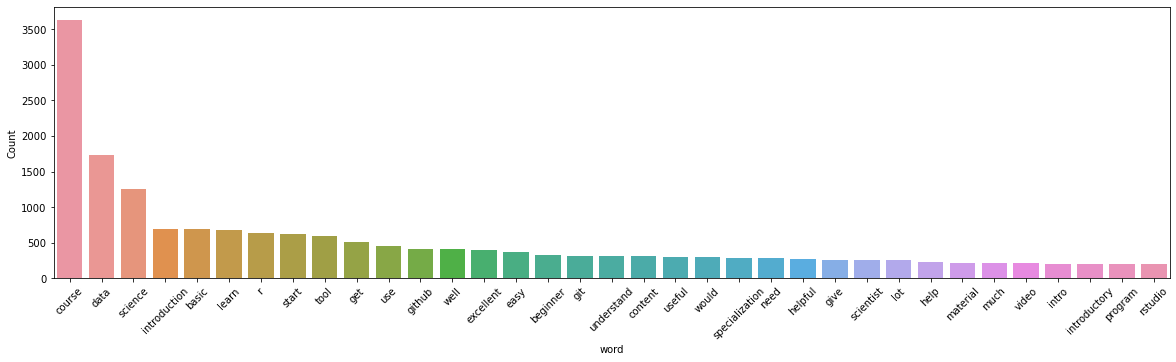

In [63]:
# Most frequent words after lemmatizing 

freq_words(df['joined'], 35)

## LDA Topic Modeling

In [64]:
# Create a dictionary from 'df_sen['review']' containing the number of times a word appears in the training set

dictionary = gensim.corpora.Dictionary(df['preprocessed'])

In [65]:
# Gensim filter extremes

# Filter out tokens that appear in:
# Less than 50 documents, more than 0.5 documents, and keep only 100000 most frquent tokens

# dictionary.filter_extremes(no_below = 50, no_above = 0.5, keep_n = 100000)

In [66]:
# Gensim doc2bow
# Create a dictionary reporting how many words and how many times those words appear

corpus = [dictionary.doc2bow(doc) for doc in df['preprocessed']]


In [67]:
# Add TF-IDF

tfidf = models.TfidfModel(corpus)      # Create a TF-IDF model
corpus_tfidf = tfidf[corpus]  

In [78]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.LdaMulticore

# Build LDA model
lda_model = LDA(corpus = corpus, id2word = dictionary, num_topics = 4, random_state = 100,
                chunksize = 100, passes = 10)

In [79]:
# Explore the words occurring in each topic and its relative weight

for id, topic in lda_model.print_topics(-1):
    print('Topic: {}\nWord: {}\n'.format(id, topic))

Topic: 0
Word: 0.059*"course" + 0.016*"content" + 0.014*"could" + 0.010*"git" + 0.010*"week" + 0.010*"little" + 0.010*"would" + 0.009*"learn" + 0.009*"intro" + 0.009*"take"

Topic: 1
Word: 0.062*"course" + 0.031*"easy" + 0.023*"excellent" + 0.013*"lot" + 0.012*"learn" + 0.012*"follow" + 0.012*"understand" + 0.010*"awesome" + 0.009*"use" + 0.009*"would"

Topic: 2
Word: 0.089*"course" + 0.084*"data" + 0.060*"science" + 0.038*"introduction" + 0.032*"tool" + 0.031*"start" + 0.031*"basic" + 0.022*"r" + 0.015*"get" + 0.013*"scientist"

Topic: 3
Word: 0.033*"course" + 0.026*"well" + 0.015*"experience" + 0.012*"learn" + 0.011*"make" + 0.011*"video" + 0.011*"material" + 0.009*"get" + 0.008*"one" + 0.008*"work"



### Visualise with pyLDAvis

Original paper: https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

In [80]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.239587 -0.011512       1        1  35.777865
0      0.056426 -0.054964       2        1  24.378595
3      0.113589 -0.097272       3        1  21.576722
1      0.069572  0.163748       4        1  18.266818, topic_info=             Term         Freq        Total Category  logprob  loglift
20           data  1529.000000  1529.000000  Default  30.0000  30.0000
30        science  1096.000000  1096.000000  Default  29.0000  29.0000
67   introduction   696.000000   696.000000  Default  28.0000  28.0000
93          start   564.000000   564.000000  Default  27.0000  27.0000
34           tool   598.000000   598.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
168           git    45.946928   298.051198   Topic4  -5.3041  -0.1697
284          help    43.626617   213.337179   Topic4  -5.3559   0.1129
528   informative    39.316099   108.998950   Topic4  -5.4599   0.6804
275         thing    37.605123   151.684780   Topic4  -5.5044   0.3054
11              r    37.574582   531.644539   Topic4  -5.5053  -0.9496

[301 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1069      2  0.933645      1
1069      3  0.066689      1
161       2  0.811276      2
161       4  0.189298      2
525       2  0.967877      3
...     ...       ...    ...
59        1  0.114298  would
59        2  0.439335  would
59        3  0.139301  would
59        4  0.307177  would
1225      3  0.941887  youll

[523 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2])

What is topic perplexity and topic coherence: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [71]:
# Calculate Perplexity and Coherence

# Compute Perplexity

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. The lower the better.

# Compute Coherence Score

coherence_model_lda = CoherenceModel(model = lda_model, texts = df['preprocessed'], dictionary = dictionary, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.658875046408961

Coherence Score:  0.45738393172386704


## Hyperparameter Tuning

Code references

Find the optimal number of topics, alpha and beta: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

What is alpha and beta: https://www.thoughtvector.io/blog/lda-alpha-and-beta-parameters-the-intuition/

## Calculate the coherence score

Code reference: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

In [72]:
# Determine the optiomal number of topics by calculating the coherence score

# Define function for calculating coherence score

def compute_coherence_values(dictionary, corpus, texts, limit, start = 2, step = 3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LDA(corpus = corpus, num_topics = num_topics, id2word = dictionary, random_state = 100,
                chunksize = 100, passes = 10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [73]:
# Can take a long time to run.

model_list, coherence_values = compute_coherence_values(dictionary = dictionary, corpus = corpus, texts = df['preprocessed'], start = 2, limit = 10, step = 1)

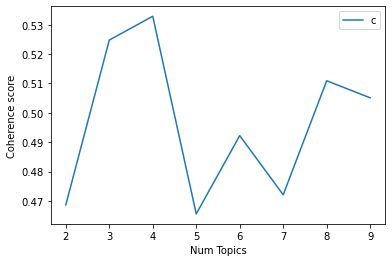

In [74]:
# Show graph

limit = 10; start = 2; step = 1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()


In [75]:
# Print the coherence scores

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4687
Num Topics = 3  has Coherence Value of 0.5248
Num Topics = 4  has Coherence Value of 0.5329
Num Topics = 5  has Coherence Value of 0.4656
Num Topics = 6  has Coherence Value of 0.4923
Num Topics = 7  has Coherence Value of 0.4721
Num Topics = 8  has Coherence Value of 0.5109
Num Topics = 9  has Coherence Value of 0.5051


## LDA Mallet Model

Code reference:

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

In [76]:
mallet_path = '/Users/siriamanda/Desktop/LNU-VT-2021/Thesis/11-data-analysis/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus = corpus, num_topics = 5, id2word = dictionary)

In [77]:
# Show Topics
pprint(ldamallet.show_topics(formatted = False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model = ldamallet, texts = df['preprocessed'], dictionary = dictionary, coherence = 'c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

# The coherence score using the Mallet Model is lower than the original LDA Model

[(0,
  [('easy', 0.05201506066099568),
   ('beginner', 0.04504253242225631),
   ('understand', 0.043926927904058014),
   ('content', 0.043648026774508436),
   ('learn', 0.03862780644261609),
   ('intro', 0.02886626690838098),
   ('program', 0.025380002789011296),
   ('follow', 0.02356714544693906),
   ('thing', 0.023148793752614697),
   ('complete', 0.02161483754009204)]),
 (1,
  [('video', 0.02747971735147867),
   ('make', 0.025255168803978018),
   ('work', 0.025255168803978018),
   ('time', 0.024077466631771786),
   ('lecture', 0.023292331850300968),
   ('voice', 0.02211462967809474),
   ('find', 0.01517927244176917),
   ('teach', 0.014655849254121958),
   ('point', 0.014263281863386547),
   ('quiz', 0.012038733315885893)]),
 (2,
  [('data', 0.2290894653255691),
   ('science', 0.16596082583377447),
   ('introduction', 0.09237691900476443),
   ('tool', 0.07980412916887242),
   ('specialization', 0.0378507146638433),
   ('scientist', 0.03480677607199577),
   ('start', 0.034674430915828